In [1]:
from matplotlib import pyplot as plt
import numpy as np
from erle import encode
from measure import measure
from rand_img import draw

def compare(bytes0, bytes1):
    len0, len1 = len(bytes0), len(bytes1)
    for i in range(max(len0, len1)):
        byte0 = bytes0[i] if i<len0 else '-'
        byte1 = bytes1[i] if i<len1 else '-'
        if byte0 != byte1:
            print(f'byte {i:>5d}: {byte0:>4}, {byte1:>4}')

def show_img(images):
    rgb = np.zeros((1080,1920,3),dtype='uint8')
    for i in range(len(images)):
        if i<8:
            rgb[:,:,2] += images[i]*(2**i)
        elif i<16:
            rgb[:,:,1] += images[i]*(2**(i-8))
        elif i<24:
            rgb[:,:,0] += images[i]*(2**(i-16))
    plt.imshow(rgb)

@measure(10)
def enc(img):
    return encode(img)

Finest resolution is 1e-07 seconds.


In [2]:
# https://github.com/csi-dcsc/Pycrafter6500/blob/master/pycrafter6500.py

numpy = np

##function that converts a number into a bit string of given length

def convlen(a,l):
    b=bin(a)[2:]
    padding=l-len(b)
    b='0'*padding+b

    return b

##function that converts a bit string into a given number of bytes

def bitstobytes(a):
    bytelist=[]
    if len(a)%8!=0:
        padding=8-len(a)%8
        a='0'*padding+a
    for i in range(len(a)//8):
        bytelist.append(int(a[8*i:8*(i+1)],2))

    bytelist.reverse()

    return bytelist

##function that encodes a 8 bit numpy array matrix as a enhanced run lenght encoded string of bits

def mergeimages(images):
    mergedimage=numpy.zeros((1080,1920,3),dtype='uint8')

    for i in range(len(images)):
        if i<8:
            mergedimage[:,:,2]=mergedimage[:,:,2]+images[i]*(2**i)
        if i>7 and i<16:
            mergedimage[:,:,1]=mergedimage[:,:,1]+images[i]*(2**(i-8))
        if i>15 and i<24:
            mergedimage[:,:,0]=mergedimage[:,:,0]+images[i]*(2**(i-16))

    return mergedimage

@measure()
def encode_pc(image): 


## header creation
    bytecount=48    
    bitstring=[]

    bitstring.append(0x53)
    bitstring.append(0x70)
    bitstring.append(0x6c)
    bitstring.append(0x64)
    
    width=convlen(1920,16)
    width=bitstobytes(width)
    for i in range(len(width)):
        bitstring.append(width[i])

    height=convlen(1080,16)
    height=bitstobytes(height)
    for i in range(len(height)):
        bitstring.append(height[i])


    total=convlen(0,32)
    total=bitstobytes(total)
    for i in range(len(total)):
        bitstring.append(total[i])        

    for i in range(8):
        bitstring.append(0xff)

    for i in range(4):    ## black curtain
        bitstring.append(0x00)

    bitstring.append(0x00)

    bitstring.append(0x02) ## enhanced rle

    bitstring.append(0x01)

    for i in range(21):
        bitstring.append(0x00)



    n=0
    i=0
    j=0

    while i <1080:
        while j <1920:
            if i>0 and numpy.all(image[i,j,:]==image[i-1,j,:]):
                while j<1920 and numpy.all(image[i,j,:]==image[i-1,j,:]):
                    n=n+1
                    j=j+1

                bitstring.append(0x00)
                bitstring.append(0x01)
                bytecount+=2
                
                if n>=128:
                    byte1=(n & 0x7f)|0x80
                    byte2=(n >> 7)
                    bitstring.append(byte1)
                    bitstring.append(byte2)
                    bytecount+=2
                    
                else:
                    bitstring.append(n)
                    bytecount+=1
                n=0

            
            else:
                if j<1919 and numpy.all(image[i,j,:]==image[i,j+1,:]):
                    n=n+1
                    while j<1919 and numpy.all(image[i,j,:]==image[i,j+1,:]):
                        n=n+1
                        j=j+1
                    if n>=128:
                        byte1=(n & 0x7f)|0x80
                        byte2=(n >> 7)
                        bitstring.append(byte1)
                        bitstring.append(byte2)
                        bytecount+=2
                        
                    else:
                        bitstring.append(n)
                        bytecount+=1

                    bitstring.append(image[i,j-1,0])
                    bitstring.append(image[i,j-1,1])
                    bitstring.append(image[i,j-1,2])
                    bytecount+=3
                    
                    j=j+1
                    n=0

                else:
                    if j>1917 or numpy.all(image[i,j+1,:]==image[i,j+2,:]) or numpy.all(image[i,j+1,:]==image[i-1,j+1,:]):
                        bitstring.append(0x01)
                        bytecount+=1
                        bitstring.append(image[i,j,0])
                        bitstring.append(image[i,j,1])
                        bitstring.append(image[i,j,2])
                        bytecount+=3
                        
                        j=j+1
                        n=0

                    else:
                        bitstring.append(0x00)
                        bytecount+=1

                        toappend=[]

                        
                        while numpy.any(image[i,j,:]!=image[i,j+1,:]) and numpy.any(image[i,j,:]!=image[i-1,j,:]) and j<1919:
                            n=n+1
                            toappend.append(image[i,j,0])
                            toappend.append(image[i,j,1])
                            toappend.append(image[i,j,2])
                            j=j+1

                        if n>=128:
                            byte1=(n & 0x7f)|0x80
                            byte2=(n >> 7)
                            bitstring.append(byte1)
                            bitstring.append(byte2)
                            bytecount+=2
                                
                        else:
                            bitstring.append(n)
                            bytecount+=1

                        for k in toappend:
                            bitstring.append(k)
                            bytecount+=1
                        n=0
        j=0
        i=i+1
        bitstring.append(0x00)
        bitstring.append(0x00)
        bytecount+=2
    bitstring.append(0x00)
    bitstring.append(0x01)
    bitstring.append(0x00)
    bytecount+=3


    while (bytecount)%4!=0:
        bitstring.append(0x00)
        bytecount+=1        

    size=bytecount
    total=convlen(size,32)
    total=bitstobytes(total)
    for i in range(len(total)):
        bitstring[i+8]=total[i]    

    return bitstring

Finest resolution is 1e-07 seconds.


# typical image for raster scanning

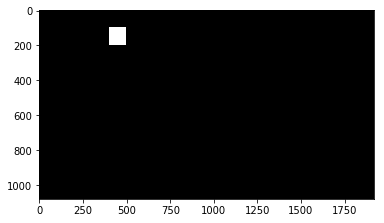

In [3]:
imgs = np.zeros((24, 1080, 1920), dtype=np.uint8)
imgs[:, 100:200, 400:500] = 1
show_img(imgs)

enc: 211.3963 milliseconds (averaged over 10 samples)


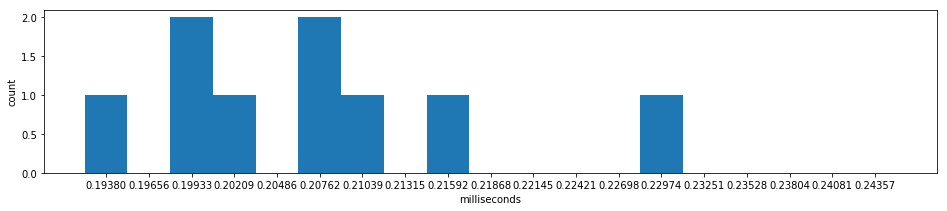

In [4]:
compressed = enc(imgs)

In [5]:
# pycrafter6500
compressed_pc = encode_pc(mergeimages(imgs))
compare(compressed_pc, compressed) # print nothing means identical

encode_pc: 9630.8862 milliseconds (averaged over 1 samples)


# random image with long runs

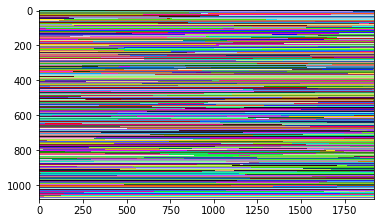

In [6]:
imgs = draw(0.001) # probability of changing color in the next pixel
show_img(imgs)

enc: 252.3394 milliseconds (averaged over 10 samples)


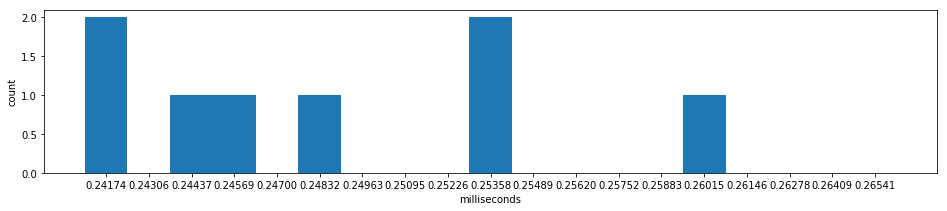

In [7]:
compressed = enc(imgs)

In [8]:
# pycrafter6500
compressed_pc = encode_pc(mergeimages(imgs))
compare(compressed_pc, compressed) # print nothing means identical

encode_pc: 10321.1794 milliseconds (averaged over 1 samples)
